In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

In [2]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=2000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

In [3]:
def encode(data_dir, csv_file):
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    data = []
    labels = []
    
    for index, row in df.iterrows():
        file_name = f"train/train/{row['idx']}.wav"
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            features = extract_features(file_path)
            data.append(features)
            labels.append(1 if row['class'] == 'RightWhale' else 0)
    
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [4]:
def matriz_confusion(y_test, y_pred, tipo):
    matrix = confusion_matrix(y_test, y_pred)
    matrix_norm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    f2 = pd.DataFrame(matrix_norm, index=["RightWhale", 'NoWhale'], columns=["RightWhale", 'NoWhale'])
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix " + tipo)
    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

In [5]:
data_dir = './data/'
train_csv = 'train.csv'


x, y = encode(data_dir, train_csv)


In [6]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

LOGISTICA

In [8]:
def h(x, w):
    return np.dot(x, w.T)

def S(x, w):
    return 1 / (1 + np.exp(-h(x, w)))

def loss(y, y_aprox):
    n = y.shape[0]
    limite = 1e-15
    s_vals = np.clip(y_aprox, 0+limite, 1-limite)
    return (-1/n) * np.sum(y * np.log2(s_vals) + (1 - y) * np.log2(1 - s_vals))

def derivatives(x, y, w):
    n, m = x.shape
    y_aprox = S(x, w)
    dw = -(1/n) * np.dot(x.T, (y - y_aprox))
    return dw

def change_parameters(w, derivatives, alpha):
    return w - alpha * derivatives

def training(x, y, epochs, alpha):
    L_value = []
    n_features = x.shape[1]
    np.random.seed(0)
    w = np.random.rand(n_features)
    for i in range(epochs):
        y_aprox = S(x, w)
        L = loss(y, y_aprox)
        dw = derivatives(x, y, w)
        w = change_parameters(w, dw, alpha)
        L_value.append(L)
    return L_value, w

In [9]:
def predict(x_test, w):
    y_pred = np.round(S(x_test, w))
    return y_pred

In [10]:
epochs = 1000
alpha = 0.08
L, W = training(x_train, y_train, epochs, alpha)

In [11]:
y_pred = predict(x_test, W)

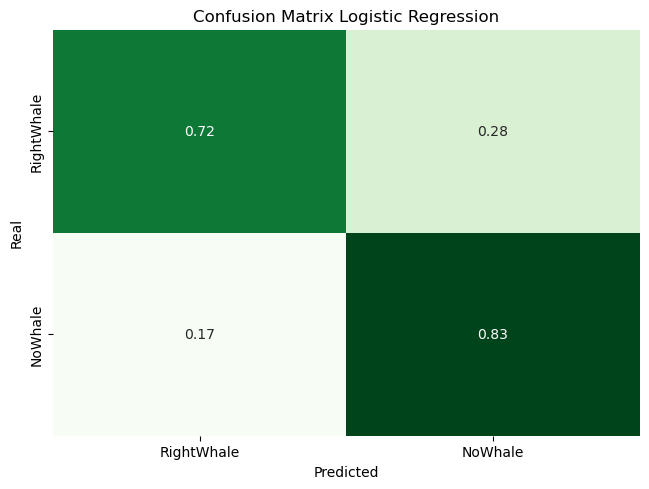

In [12]:
matriz_confusion(y_test, y_pred, "Logistic Regression")

In [13]:
report = classification_report(y_test, y_pred, target_names=["RightWhale", 'NoWhale'])
print(" My Model Metrics ")
print(report)

 My Model Metrics 
              precision    recall  f1-score   support

  RightWhale       0.80      0.72      0.76      1059
     NoWhale       0.76      0.83      0.79      1128

    accuracy                           0.78      2187
   macro avg       0.78      0.77      0.77      2187
weighted avg       0.78      0.78      0.78      2187



In [14]:
def extract_test_features(data_dir):
    test_dir = os.path.join(data_dir, 'test/test')
    test_files = sorted(os.listdir(test_dir))
    test_data = []
    test_ids = []
    
    for file_name in test_files:
        if file_name.endswith('.wav'):
            file_path = os.path.join(test_dir, file_name)
            features = extract_features(file_path)
            test_data.append(features)
            test_ids.append(int(file_name.split('.')[0]))  
            
    test_data = np.array(test_data)
    return test_data, test_ids

In [15]:
x_test_final, test_ids = extract_test_features(data_dir)

x_test_final_scaled = scaler.transform(x_test_final)

y_pred_final = predict(x_test_final_scaled, W)

## Grafico del loss

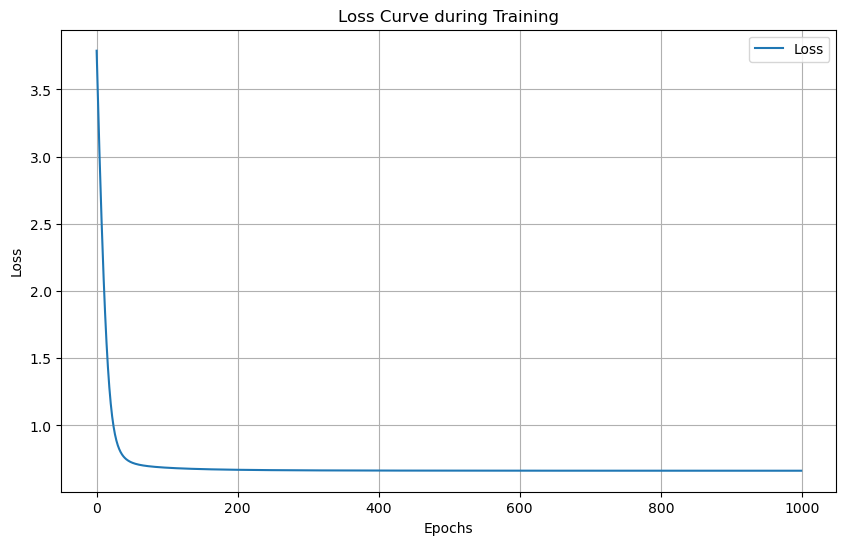

In [19]:

def plot_loss_curve(loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve during Training')
    plt.legend()
    plt.grid(True)
    plt.show()

 
plot_loss_curve(L)